In [1]:
!pip install kagglehub tensorflow opencv-python-headless numpy pandas scikit-learn
import kagglehub
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

In [9]:
def download_dataset():
    """Download the Sri Lanka vehicle number plates dataset"""
    dataset_path = kagglehub.dataset_download(
        'rohankumara/sri-lanka-vehicle-number-plates'
    )
    print(f"Dataset downloaded to: {dataset_path}")
    return dataset_path

In [14]:
def enhance_contrast(img):
    """Enhance image contrast using CLAHE"""
    # Convert to LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)

    # Split the LAB image into L, A, and B channels
    l, a, b = cv2.split(lab)

    # Apply CLAHE to L channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    l_enhanced = clahe.apply(l)

    # Merge the enhanced L channel with original A and B channels
    lab_enhanced = cv2.merge([l_enhanced, a, b])

    # Convert back to RGB
    enhanced = cv2.cvtColor(lab_enhanced, cv2.COLOR_LAB2RGB)
    return enhanced


In [15]:
def load_and_preprocess_images(dataset_path, target_size=(224, 224)):
    """Load and preprocess images in one step to ensure consistent sizes"""
    processed_images = []
    plates = []

    print("Processing images...")
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                try:
                    # Construct full path
                    img_path = os.path.join(root, file)

                    # Read image
                    img = cv2.imread(img_path)
                    if img is None:
                        print(f"Failed to load image: {img_path}")
                        continue

                    # Resize
                    img_resized = cv2.resize(img, target_size)

                    # Convert to RGB
                    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)

                    # Enhance contrast
                    img_enhanced = enhance_contrast(img_rgb)

                    # Normalize
                    img_normalized = img_enhanced.astype(np.float32) / 255.0

                    processed_images.append(img_normalized)

                    # Extract plate number from filename
                    plate = os.path.splitext(file)[0]
                    plates.append(plate)

                    if len(processed_images) % 50 == 0:
                        print(f"Processed {len(processed_images)} images")

                except Exception as e:
                    print(f"Error processing {file}: {str(e)}")
                    continue

    if not processed_images:
        raise ValueError("No images were successfully processed")

    return np.array(processed_images), np.array(plates)


In [16]:
def create_model(input_shape=(224, 224, 3)):
    """Create CNN model for license plate detection"""
    model = models.Sequential([
        # First Convolutional Block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Third Convolutional Block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Dense Layers
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(4, activation='sigmoid')  # [x, y, width, height]
    ])

    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mae']
    )

    return model

In [19]:
def train_model(model, X_train, y_train, X_val, y_val, epochs=5):
    """Train the model with callbacks"""
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=3
        )
    ]

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        validation_data=(X_val, y_val),
        batch_size=32,
        callbacks=callbacks
    )

    return history


Dataset downloaded to: /root/.cache/kagglehub/datasets/rohankumara/sri-lanka-vehicle-number-plates/versions/1
Loading and preprocessing images...
Processing images...
Processed 50 images
Processed 100 images
Processed 150 images
Processed 200 images
Processed 250 images
Successfully loaded and processed 251 images
Splitting dataset...
Creating model...


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │      25,690,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,785,540 (98.36 MB)

 Trainable params: 25,785,092 (98.36 MB)

 Non-trainable params: 448 (1.75 KB)

Training model...
Epoch 1/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 43s 6s/step - loss: 0.2872 - mae: 0.4488 - val_loss: 0.3346 - val_mae: 0.4996 - learning_rate: 0.0010
Epoch 2/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 43s 6s/step - loss: 0.3157 - mae: 0.4776 - val_loss: 0.3228 - val_mae: 0.4911 - learning_rate: 0.0010
Epoch 3/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 78s 6s/step - loss: 0.3299 - mae: 0.4931 - val_loss: 0.3415 - val_mae: 0.5059 - learning_rate: 0.0010
Epoch 4/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 39s 6s/step - loss: 0.3273 - mae: 0.4878 - val_loss: 0.3277 - val_mae: 0.4938 - learning_rate: 0.0010
Epoch 5/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 45s 6s/step - loss: 0.3121 - mae: 0.4767 - val_loss: 0.3168 - val_mae: 0.4854 - learning_rate: 0.0010


Model saved as 'license_plate_detector.h5'


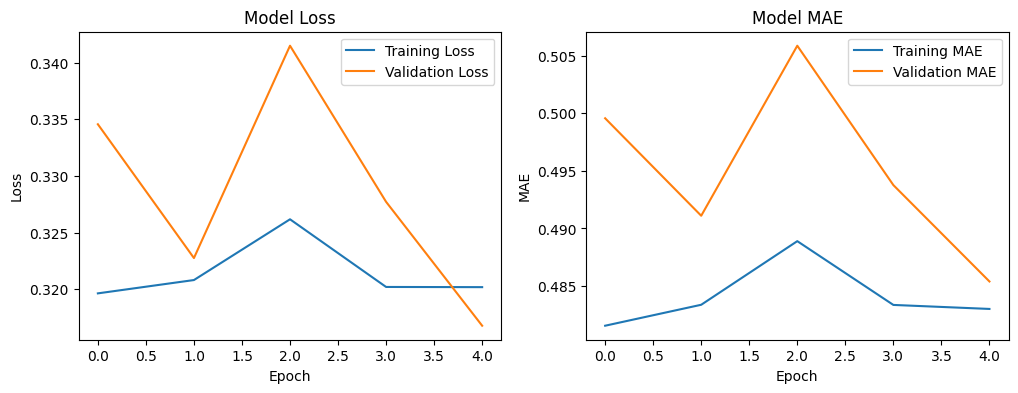

In [20]:
def main():
    try:
        # Download dataset
        print("Downloading dataset...")
        dataset_path = download_dataset()

        # Load and preprocess images
        print("Loading and preprocessing images...")
        processed_images, plates = load_and_preprocess_images(dataset_path)
        print(f"Successfully loaded and processed {len(processed_images)} images")

        # Create dummy bounding boxes for now
        bboxes = np.random.rand(len(processed_images), 4)

        # Split dataset
        print("Splitting dataset...")
        X_train, X_val, y_train, y_val = train_test_split(
            processed_images, bboxes, test_size=0.2, random_state=42
        )

        # Create and train model
        print("Creating model...")
        model = create_model()
        model.summary()

        print("Training model...")
        history = train_model(model, X_train, y_train, X_val, y_val)

        # Save model
        model.save('license_plate_detector.h5')
        print("Model saved as 'license_plate_detector.h5'")

        # Plot training history
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history['mae'], label='Training MAE')
        plt.plot(history.history['val_mae'], label='Validation MAE')
        plt.title('Model MAE')
        plt.xlabel('Epoch')
        plt.ylabel('MAE')
        plt.legend()
        plt.show()

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        raise

if __name__ == "__main__":
    main()

In [23]:
# Load the base model
model = tf.keras.models.load_model('license_plate_detector.h5', compile=False)

# Recompile the model with the correct loss function
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.MeanSquaredError(),  # Using MSE loss explicitly
    metrics=['mae']
)


Testing image: 11.jpg


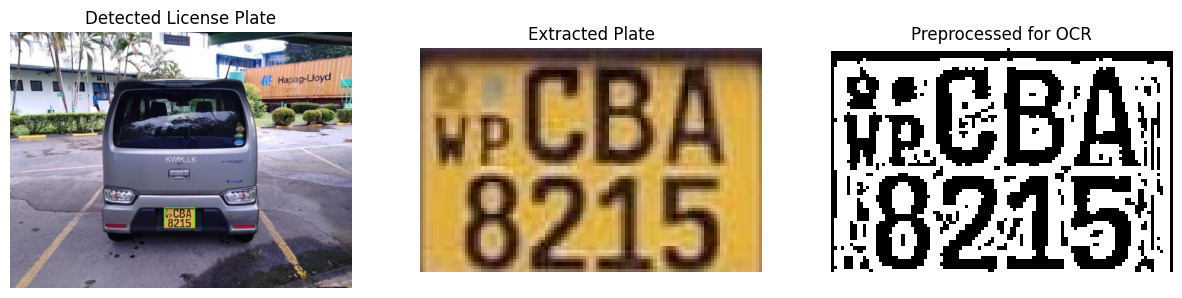

--------------------------------------------------

Testing image: 40.jpg


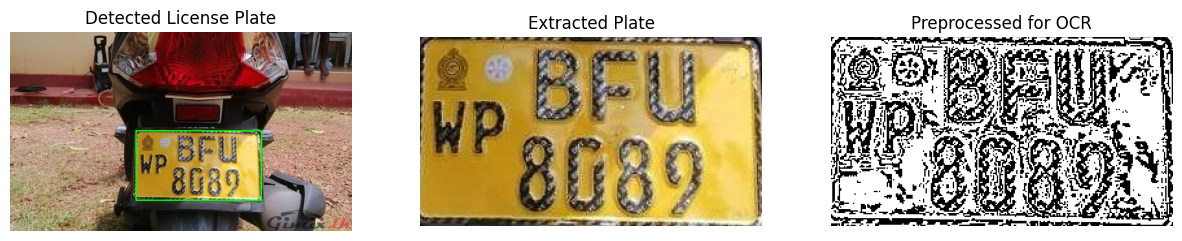

--------------------------------------------------

Testing image: 57.jpg


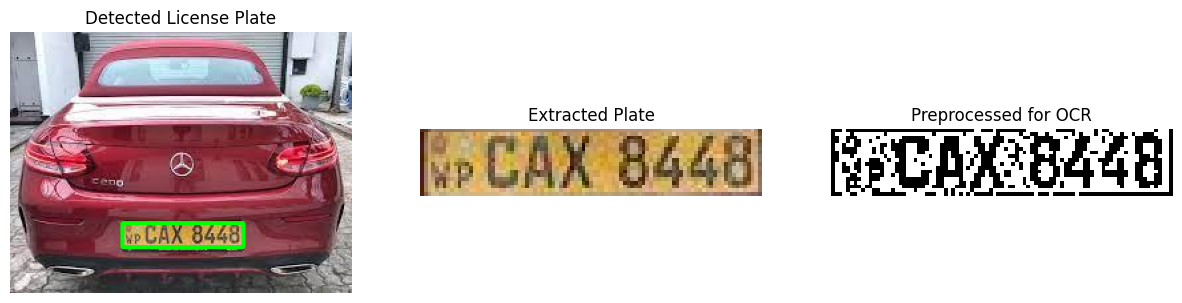

--------------------------------------------------
Missing files for image 62.97


In [48]:
def parse_annotation(xml_path):
    """Parse XML annotation file to get bounding box coordinates"""
    tree = ET.parse(xml_path)
    root = tree.getroot()

    # Get image size
    size = root.find('size')
    width = int(size.find('width').text)
    height = int(size.find('height').text)

    # Get bounding box
    obj = root.find('object')
    bbox = obj.find('bndbox')
    xmin = int(bbox.find('xmin').text)
    ymin = int(bbox.find('ymin').text)
    xmax = int(bbox.find('xmax').text)
    ymax = int(bbox.find('ymax').text)

    return {
        'width': width,
        'height': height,
        'bbox': (xmin, ymin, xmax-xmin, ymax-ymin)
    }

def test_image_with_annotation(model, image_path, xml_path):
    # Read image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not read image at {image_path}")
        return None, None

    # Get ground truth annotation
    annotation = parse_annotation(xml_path)
    x, y, w, h = annotation['bbox']

    # Extract plate region using annotation
    plate_region = img[y:y+h, x:x+w]

    # Draw rectangle
    img_with_box = img.copy()
    cv2.rectangle(img_with_box, (x, y), (x+w, y+h), (0, 255, 0), 2)

    # Preprocess plate for OCR
    try:
        # Convert to grayscale
        gray = cv2.cvtColor(plate_region, cv2.COLOR_BGR2GRAY)

        # Apply CLAHE for better contrast
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        enhanced = clahe.apply(gray)

        # Denoise
        denoised = cv2.fastNlMeansDenoising(enhanced)

        # Adaptive thresholding
        thresh = cv2.adaptiveThreshold(denoised, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                     cv2.THRESH_BINARY, 11, 2)

        # Additional preprocessing for yellow plates
        _, yellow_mask = cv2.threshold(enhanced, 150, 255, cv2.THRESH_BINARY)

    except Exception as e:
        print(f"Error in preprocessing: {str(e)}")
        return None, None

    # Display results
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(img_with_box, cv2.COLOR_BGR2RGB))
    plt.title('Detected License Plate')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(plate_region, cv2.COLOR_BGR2RGB))
    plt.title('Extracted Plate')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(thresh, cmap='gray')
    plt.title('Preprocessed for OCR')
    plt.axis('off')

    plt.show()

    return annotation['bbox'], plate_region

def test_multiple_images(dataset_path, image_numbers):
    for num in image_numbers:
        image_path = os.path.join(dataset_path, 'Numberplate', f'{num}.jpg')
        xml_path = os.path.join(dataset_path, 'Numberplate', f'{num}.xml')

        if os.path.exists(image_path) and os.path.exists(xml_path):
            print(f"\nTesting image: {num}.jpg")
            bbox, plate = test_image_with_annotation(None, image_path, xml_path)
            print("-" * 50)
        else:
            print(f"Missing files for image {num}")

# Test the images
dataset_path = '/root/.cache/kagglehub/datasets/rohankumara/sri-lanka-vehicle-number-plates/versions/1'
test_multiple_images(dataset_path, [11, 40, 57, 62.97])